In [28]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer in sklearn
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lifelines import CoxPHFitter
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
from xgboost import XGBClassifier






In [29]:
# Load datasets
adnimerge_path = "ADNIMERGE_CLEAN.csv"
df= pd.read_csv(adnimerge_path)


C:\Users\何扬帆\AppData\Local\Temp\ipykernel_38344\584643071.py:3: DtypeWarning: Columns (15,16,17,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,99,101,103,105,124,126,128,129,130,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(adnimerge_path)


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Columns: 299 entries, Unnamed: 0 to DX_VISIT25
dtypes: float64(237), int64(4), object(58)
memory usage: 5.2+ MB


In [31]:

dtypes_df = pd.DataFrame({
    'Column': df.columns,
    'DataType': df.dtypes.values
})

# Force print without truncation
dtypes_df.to_csv("column_dtypes.csv", index=False)




In [32]:
def clean_biomarker_value(x):
    try:
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x.startswith('>') or x.startswith('<'):
            x = x[1:]
        return float(x)
    except:
        return np.nan


In [33]:
biomarkers = ['ABETA', 'TAU', 'PTAU']
columns_to_clean = [f"{b}_bl" for b in biomarkers] + [f"{b}_VISIT{i}" for b in biomarkers for i in range(1, 26)]
columns_to_clean = [col for col in columns_to_clean if col in df.columns]

for col in columns_to_clean:
    df[col] = df[col].apply(clean_biomarker_value).astype('float64')


In [34]:
df['EXAMDATE_bl'] = pd.to_datetime(df['EXAMDATE_bl'], format='%Y-%m-%d')

df['PTGENDER'] = df['PTGENDER'].astype('category')
df['PTETHCAT'] = df['PTETHCAT'].astype('category')
df['PTRACCAT'] = df['PTRACCAT'].astype('category')
df['PTMARRY'] = df['PTMARRY'].astype('category')

# List all target biomarker column prefixes
biomarker_prefixes = ['ABETA', 'TAU', 'PTAU']
# Build full list of column names
columns_to_convert = []

for prefix in biomarker_prefixes:
    columns_to_convert.append(f'{prefix}_bl')  # baseline
    columns_to_convert.extend([f'{prefix}_VISIT{i}' for i in range(1, 26)])  # visit 1–25

# Filter to only existing columns in your DataFrame
columns_to_convert = [col for col in columns_to_convert if col in df.columns]



In [35]:


# Convert to float64
df[columns_to_convert] = df[columns_to_convert].astype('float64')

# Create a list of diagnosis visit column names
dx_columns = [f'DX_VISIT{i}' for i in range(1, 26)]

# Convert those columns to category dtype
df[dx_columns] = df[dx_columns].astype('category')


In [36]:
dtypes_df = pd.DataFrame({
    'Column': df.columns,
    'DataType': df.dtypes.values
})

# Force print without truncation
dtypes_df.to_csv("column_dtypes_new.csv", index=False)


In [37]:
df.to_csv("check.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Columns: 299 entries, Unnamed: 0 to DX_VISIT25
dtypes: category(29), datetime64[ns](1), float64(264), int64(4), object(1)
memory usage: 4.8+ MB


In [39]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore')
df.to_csv('check.csv')


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Columns: 298 entries, RID to DX_VISIT25
dtypes: category(29), datetime64[ns](1), float64(264), int64(3), object(1)
memory usage: 4.8+ MB


In [41]:

# Load your dataset
df = pd.read_csv('check.csv')

# Define column prefixes
col_prefixes = [
    'AGE_VISIT', 'APOE4_VISIT', 'ABETA_VISIT', 'TAU_VISIT', 'PTAU_VISIT',
    'CDRSB_VISIT', 'ADAS11_VISIT', 'ADAS13_VISIT', 'ADASQ4_VISIT', 
    'MMSE_VISIT', 'DX_VISIT'
]

# Shift data to fill blanks for each prefix group
for prefix in col_prefixes:
    cols = [f'{prefix}{i}' for i in range(1, 26) if f'{prefix}{i}' in df.columns]
    
    # Shift non-NaN values left for each row
    shifted_data = df[cols].apply(
        lambda row: row.dropna().tolist() + [np.nan]*(len(row)-row.count()), axis=1, result_type='expand'
    )
    
    # Replace original columns with shifted data
    shifted_data.columns = cols
    df[cols] = shifted_data

# Remove columns entirely NaN after shifting (if any)
df.dropna(axis=1, how='all', inplace=True)

# Save the final adjusted data
df.to_csv('Integrated_ADNIMERGE_shifted.csv', index=False)


C:\Users\何扬帆\AppData\Local\Temp\ipykernel_38344\2459352920.py:2: DtypeWarning: Columns (279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('check.csv')


In [42]:
df=pd.read_csv('Integrated_ADNIMERGE_shifted.csv')

In [43]:
# Get all AGE_VISIT columns
age_cols = [col for col in df.columns if col.startswith("AGE_VISIT")]

# Define a function to check if all age values are the same (ignoring NaN)
def is_age_consistent(row):
    ages = row[age_cols].dropna().values
    return len(set(ages)) == 1 if len(ages) > 0 else False

# Apply function and filter dataset
consistent_age_df = df[df.apply(is_age_consistent, axis=1)][['RID']]
# Define a function to check if all non-NaN age values are the same
def is_age_inconsistent(row):
    values = row[age_cols].dropna().values
    return len(set(values)) > 1

# Filter rows where age is inconsistent
inconsistent_age_df = df[df.apply(is_age_inconsistent, axis=1)]

# Save or display the result
inconsistent_age_df.to_csv("inconsistent_age_rows.csv", index=False)
print(inconsistent_age_df[['RID'] + age_cols].head())
# Save or display the result
consistent_age_df.to_csv("consistent_age_RIDs.csv", index=False)
print(consistent_age_df.head())

Empty DataFrame
Columns: [RID, AGE_VISIT1, AGE_VISIT2, AGE_VISIT3, AGE_VISIT4, AGE_VISIT5, AGE_VISIT6, AGE_VISIT7, AGE_VISIT8, AGE_VISIT9, AGE_VISIT10, AGE_VISIT11, AGE_VISIT12, AGE_VISIT13, AGE_VISIT14, AGE_VISIT15, AGE_VISIT16, AGE_VISIT17, AGE_VISIT18, AGE_VISIT19, AGE_VISIT20, AGE_VISIT21, AGE_VISIT22, AGE_VISIT23, AGE_VISIT24, AGE_VISIT25]
Index: []

[0 rows x 26 columns]
   RID
0    3
1    4
2    5
3    6
4    7


In [44]:
df.dropna(axis=1, thresh=0.5*len(df), inplace=True)  # Remove columns missing >20% of values


In [45]:
df['EXAMDATE_bl'] = pd.to_datetime(df['EXAMDATE_bl'], format='%Y-%m-%d')

df['PTGENDER'] = df['PTGENDER'].astype('category')
df['PTETHCAT'] = df['PTETHCAT'].astype('category')
df['PTRACCAT'] = df['PTRACCAT'].astype('category')
df['PTMARRY'] = df['PTMARRY'].astype('category')
df['SITE'] = df['SITE'].astype('category')
# Create a list of diagnosis visit column names
dx_columns = [f'DX_VISIT{i}' for i in range(1, 5)]

# Convert those columns to category dtype
df[dx_columns] = df[dx_columns].astype('category')

In [46]:
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     2282 non-null   int64         
 1   RID            2282 non-null   int64         
 2   PTID           2282 non-null   object        
 3   SITE           2282 non-null   category      
 4   PTGENDER       2282 non-null   category      
 5   PTEDUCAT       2282 non-null   int64         
 6   PTETHCAT       2282 non-null   category      
 7   PTRACCAT       2282 non-null   category      
 8   PTMARRY        2281 non-null   category      
 9   EXAMDATE_bl    2282 non-null   datetime64[ns]
 10  CDRSB_bl       2282 non-null   float64       
 11  ADAS11_bl      2270 non-null   float64       
 12  ADAS13_bl      2259 non-null   float64       
 13  ADASQ4_bl      2275 non-null   float64       
 14  MMSE_bl        2281 non-null   float64       
 15  FDG_bl         1387 n

Unnamed: 0                int64
RID                       int64
PTID                     object
SITE                   category
PTGENDER               category
PTEDUCAT                  int64
PTETHCAT               category
PTRACCAT               category
PTMARRY                category
EXAMDATE_bl      datetime64[ns]
CDRSB_bl                float64
ADAS11_bl               float64
ADAS13_bl               float64
ADASQ4_bl               float64
MMSE_bl                 float64
FDG_bl                  float64
Years_bl                float64
Month_bl                float64
AGE_VISIT1              float64
AGE_VISIT2              float64
AGE_VISIT3              float64
AGE_VISIT4              float64
AGE_VISIT5              float64
APOE4_VISIT1            float64
APOE4_VISIT2            float64
APOE4_VISIT3            float64
APOE4_VISIT4            float64
APOE4_VISIT5            float64
ABETA_VISIT1            float64
TAU_VISIT1              float64
PTAU_VISIT1             float64
CDRSB_VI

In [47]:
df.to_csv('check2.csv')

In [58]:
df = pd.read_csv("check2.csv")
df=df.drop(columns='Unnamed: 0')

In [59]:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("check2.csv")

categorical_vars = ['SITE', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_vars] = cat_imputer.fit_transform(df[categorical_vars])

# One-hot encode categorical variables 
ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded = ohe.fit_transform(df[categorical_vars])
encoded_cols = ohe.get_feature_names_out(categorical_vars)
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

# Merge encoded columns back
df = pd.concat([df.drop(columns=categorical_vars), df_encoded], axis=1)

# Impute APOE4 (static biological marker)
for v in range(1, 5):
    col = f"APOE4_VISIT{v}"
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Forward-fill & median-impute biomarker values across visits
biomarkers = ['ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']
for b in biomarkers:
    visit_cols = [f"{b}_VISIT{v}" for v in range(1, 5) if f"{b}_VISIT{v}" in df.columns]
    # Forward fill across visits
    df[visit_cols] = df[visit_cols].apply(lambda row: row.ffill(axis=0), axis=1)
    # Fill remaining NaNs with median
    for col in visit_cols:
        df[col] = df[col].fillna(df[col].median())

#  Mark diagnosis columns as categorical for future label encoding
dx_cols = [f"DX_VISIT{v}" for v in range(1, 5) if f"DX_VISIT{v}" in df.columns]
for col in dx_cols:
    df[col] = df[col].astype("category")

df[dx_cols].head()


,DX_VISIT1,DX_VISIT2,DX_VISIT3,DX_VISIT4
0,Dementia,Dementia,Dementia,Dementia
1,MCI,MCI,MCI,MCI
2,CN,CN,CN,CN
3,MCI,MCI,MCI,MCI
4,Dementia,Dementia,Dementia,Dementia


In [60]:
df.info()
df.to_csv('check3.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Columns: 130 entries, Unnamed: 0.1 to PTMARRY_Widowed
dtypes: category(4), float64(120), int64(4), object(2)
memory usage: 2.2+ MB


In [ ]:
import pandas as pd

# Load your datasets
check3 = pd.read_csv("check3.csv")
rurality = pd.read_csv("All_Subjects_RURALITY_07Mar2025.csv")

# Identify one-hot SITE columns
site_columns = [col for col in check3.columns if col.startswith("SITE_")]

# Create SITE to RUCA mapping
site_ruca_map = rurality[["SITEID", "RUCA"]].dropna().drop_duplicates()
site_to_ruca = {f"SITE_{int(row.SITEID)}": int(row.RUCA) for _, row in site_ruca_map.iterrows()}

# Replace SITE columns with RUCA columns
for site_col in site_columns:
    if site_col in site_to_ruca:
        ruca_val = site_to_ruca[site_col]
        ruca_col = f"RUCA_{ruca_val}"
        if ruca_col not in check3.columns:
            check3[ruca_col] = 0
        check3[ruca_col] = check3[ruca_col].astype(int) | check3[site_col].fillna(0).astype(int)

# Drop SITE columns
check3.drop(columns=site_columns, inplace=True)

# Extract the RUCA value from the one-hot columns
def extract_ruca_value(row):
    for col in row.index:
        if col.startswith("RUCA_") and row[col] == 1:
            return int(col.replace("RUCA_", ""))
    return None

check3["RUCA_VALUE"] = check3.apply(extract_ruca_value, axis=1)

# Add binary flags
check3["RUCA_URBAN"] = check3["RUCA_VALUE"].apply(lambda x: 1 if x == 2 else 0)
check3["RUCA_RURAL"] = check3["RUCA_VALUE"].apply(lambda x: 1 if x == 1 else 0)
check3["RUCA_UNKNOWN"] = check3["RUCA_VALUE"].apply(lambda x: 1 if pd.isna(x) or x not in [1,2] else 0)

check3.drop(columns=["RUCA_1", "RUCA_2", "RUCA_VALUE"], inplace=True)

# Optional: save to CSV
check3.to_csv("DATA.csv", index=False)


In [ ]:
df=df.drop(columns=['Unnamed: 0.1','Unnamed: 0','AGE_VISIT2','AGE_VISIT3','AGE_VISIT4','AGE_VISIT5'])


KeyError: "['Unnamed: 0.1', 'Unnamed: 0', 'AGE_VISIT2', 'AGE_VISIT3', 'AGE_VISIT4', 'AGE_VISIT5'] not found in axis"

In [65]:
df = df.rename(columns={'AGE_VISIT1': 'AGE'})

df.to_csv('check3.csv')

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("DATA.csv")

# Identify DX columns
dx_cols = [col for col in df.columns if col.startswith("DX_VISIT")]

# Sort DX columns by visit number
dx_cols_sorted = sorted(dx_cols, key=lambda x: int(x.split("VISIT")[1]))

# Apply row-wise forward fill (LOCF) for DX columns
df[dx_cols_sorted] = df[dx_cols_sorted].apply(lambda row: row.ffill(axis=0), axis=1)

# Save the updated DataFrame back to the CSV
df.to_csv("DATA.csv", index=False)

print("Missing DX values filled using LOCF and saved to DATA.csv.")



C:\Users\何扬帆\AppData\Local\Temp\ipykernel_17388\593257150.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[dx_cols_sorted] = df[dx_cols_sorted].apply(lambda row: row.ffill(axis=0), axis=1)


Missing DX values filled using LOCF and saved to DATA.csv.


In [66]:
print(df.columns)


Index(['RID', 'PTID', 'PTEDUCAT', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'FDG_bl',
       ...
       'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White',
       'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Unknown',
       'PTMARRY_Widowed'],
      dtype='object', length=124)


In [67]:

# Define predictor categories
# Updated predictor categories after one-hot encoding
demographics = [
    'AGE',
    'PTGENDER_Male',
    'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI','PTRACCAT_More than one','PTRACCAT_Unknown','PTRACCAT_White',
    'PTMARRY_Married', 'PTMARRY_Widowed','PTMARRY_Never married','PTMARRY_Unknown'
]


ses_factors = [
    'SITE_3', 'SITE_5','SITE_6','SITE_7','SITE_9','SITE_10','SITE_11','SITE_12','SITE_13','SITE_14','SITE_16','SITE_18','SITE_19',
    'SITE_20','SITE_21','SITE_22','SITE_23','SITE_24','SITE_27','SITE_29','SITE_31','SITE_32','SITE_33','SITE_35','SITE_36','SITE_37',
    'SITE_41','SITE_51','SITE_52','SITE_53','SITE_57','SITE_62','SITE_67','SITE_68','SITE_70','SITE_72','SITE_73','SITE_82','SITE_94',
    'SITE_98','SITE_99','SITE_100','SITE_109','SITE_114','SITE_116','SITE_121','SITE_123','SITE_126','SITE_127','SITE_128','SITE_129',
    'SITE_130','SITE_131','SITE_132','SITE_133','SITE_135','SITE_136','SITE_137','SITE_141','SITE_153','SITE_168','SITE_177','SITE_301',
    'SITE_305','SITE_341','SITE_941',
    'PTEDUCAT'
]

biomarkers = ['APOE4', 'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']

# Build visit-specific feature sets
visit_data = {}
for visit in range(1, 5):
    visit_biomarkers = [f"{b}_VISIT{visit}" for b in biomarkers if f"{b}_VISIT{visit}" in df.columns]
    available_predictors = demographics + ses_factors + visit_biomarkers
    target = f"DX_VISIT{visit}" if f"DX_VISIT{visit}" in df.columns else None
    if target:
        visit_data[f"VISIT{visit}"] = {
            "predictors": available_predictors,
            "target": target
        }

In [68]:
# Group biomarkers for LOCF (Last Observation Carried Forward)
from collections import defaultdict

biomarker_visits = []
for b in biomarkers:
    for v in range(1, 5):
        col = f"{b}_VISIT{v}"
        if col in df.columns:
            biomarker_visits.append(col)

biomarker_groups = defaultdict(list)
for col in biomarker_visits:
    base = col.split("_VISIT")[0]
    biomarker_groups[base].append(col)

# Apply forward fill across visits row-wise
for base, cols in biomarker_groups.items():
    cols_sorted = sorted(cols, key=lambda x: int(x.split("VISIT")[1]))
    df[cols_sorted] = df[cols_sorted].apply(lambda row: row.ffill(axis=0), axis=1)

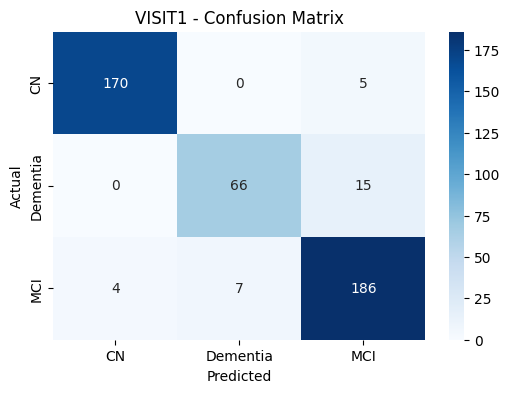

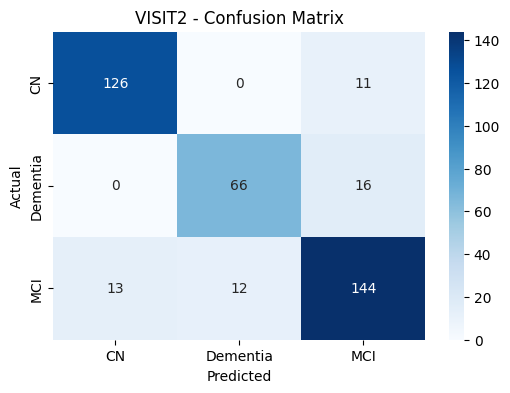

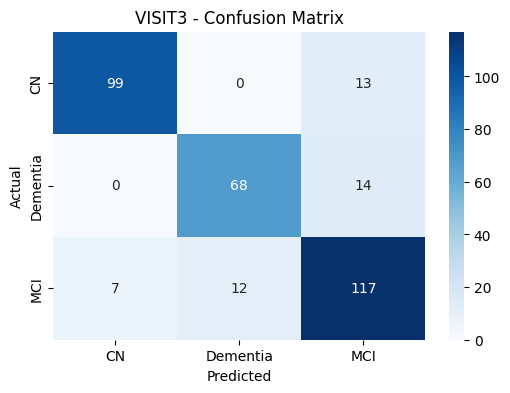

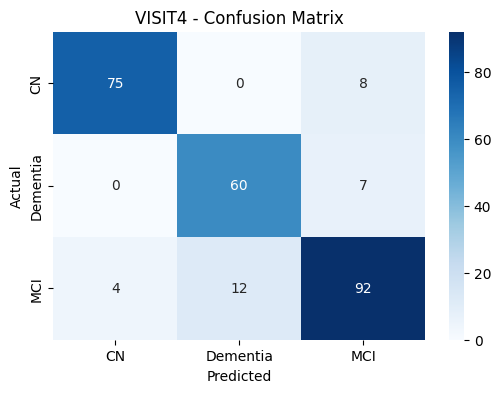

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

results = {}

for visit in range(1, 5):
    visit_key = f"VISIT{visit}"
    if visit_key not in visit_data:
        continue

    predictors = visit_data[visit_key]["predictors"]
    target = visit_data[visit_key]["target"]

    data = df[predictors + [target]].copy()
    data.dropna(subset=[target], inplace=True)

    for col in demographics + ['SITE']:
        if col in data.columns:
            data[col] = data[col].astype("category").cat.codes

    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(data[predictors])
    y = data[target].astype(str)

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    results[visit_key] = {
        "accuracy": acc,
        "report": report,
        "confusion_matrix": cm,
        "labels": le.classes_
    }

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{visit_key} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [70]:
# Identify all columns that start with DX_VISIT (e.g., DX_VISIT1, DX_VISIT2, ...)
dx_cols = [col for col in df.columns if col.startswith("DX_VISIT")]
# Label is 1 if Dementia appears in any DX_VISIT column, else 0
df["converted_to_AD"] = df[dx_cols].apply(lambda row: "Dementia" in row.values, axis=1).astype(int)


In [71]:

dx_cols = [col for col in df.columns if col.startswith("DX_VISIT")]
df["final_dx"] = df[dx_cols].bfill(axis=1).iloc[:, -1]  # Last non-null diagnosis
y = df["final_dx"]
